# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from sklearn.model_selection import train_test_split

from lightning import Trainer

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    read_fixed_labels_mask,
    train_test_split_by_mask,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_epoch_generic,
    plot_masked_segmentation_comparison,
)

from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    lightning_metrics,
)
from src.util.list_ext import smooth_moving_average
from src.util.scheduler import CosineLRSchedulerWrapper
from src.model.dbda import DBDA
from src.util.dict_ext import arrange_and_repeat

2. Prepare env

In [2]:
learning_rate = 1e-3
weight_decay = 0
num_epochs = 300

In [3]:
batch_size = 64
patch_size = 9
target_dim = 75

examples_per_class = {}

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = arrange_and_repeat(num_classes, 20)

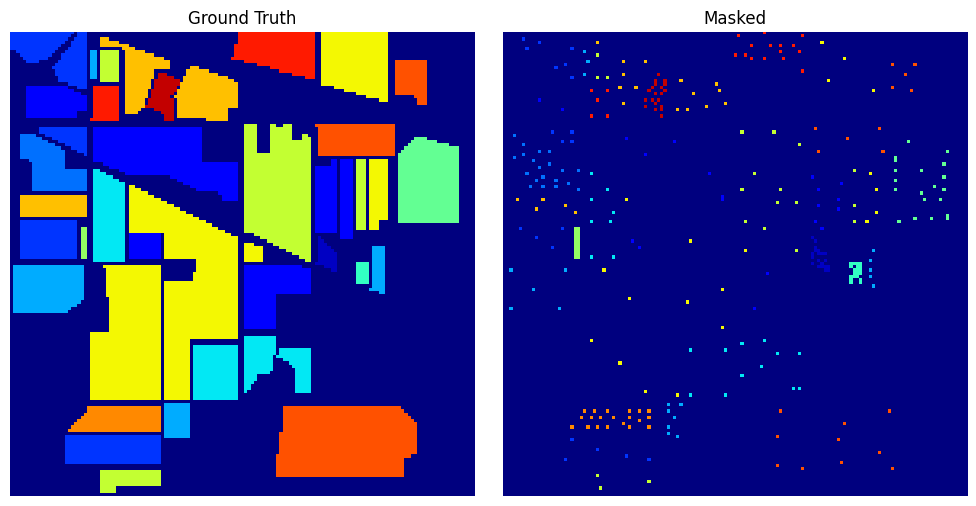

In [14]:
mask = read_fixed_labels_mask("indian-pines-v1.npy")

x_train, y_train, x_test, y_test = train_test_split_by_mask(x, y, mask)

_ = plot_masked_segmentation_comparison(y.reshape(image_h, image_w), mask)

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [17]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [18]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [ ]:
model = HyperSpectralImageClassifier(
    DBDA(
        band=target_dim,
        classes=num_classes,
    ),
    num_classes,
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler=lambda optimizer: CosineLRSchedulerWrapper(
        optimizer,
        t_initial=num_epochs,
        lr_min=learning_rate * 0.01,
        warmup_t=int(np.ceil(0.1 * num_epochs)),
        warmup_lr_init=learning_rate * 0.01,
    ),
)

trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

In [ ]:
trainer.fit(
    model,
    train_loader, 
    # test_loader,
)

In [ ]:
# smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)
# smothed_eval = smooth_moving_average([it.loss.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic_comparison(smothed_train, smothed_eval)

In [ ]:
smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)

plot_epoch_generic(smothed_train, desc="Loss")

In [ ]:
# smooth_f1 = smooth_moving_average([it.f1.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic(smooth_f1, desc="F1")

In [ ]:
validation_result = trainer.validate(model, full_loader)

validation_result

2. Display prediction

In [ ]:
y_pred = trainer.predict(model, predict_loader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

6. Write report

In [19]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "dbda"

In [ ]:
run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Add PCA, scheduler, bigger lr, v3 fixed ds",
    run_params=run_params | model.get_params(),
    run_metrics=lightning_metrics(validation_result),
)

In [ ]:
read_report_to_show(model_name, sort_by_metric="f1")

In [20]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
61,2025-05-30T18:38:35.926843+00:00,"Add PCA, scheduler, bigger lr, v3 fixed ds","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",3.566643,0.703670,0.481102,0.670345,0.506472
56,2025-05-30T12:27:26.406124+00:00,"Add PCA, scheduler, bigger lr, fixed ds","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",4.663567,0.690509,0.462844,0.655838,0.488072
60,2025-05-30T18:35:43.973805+00:00,"Add PCA, scheduler, bigger lr, newer fixed ds","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",3.839921,0.688104,0.458919,0.654221,0.489939
59,2025-05-30T18:25:28.893737+00:00,"Add PCA, scheduler, bigger lr, new fixed ds","{""num_epochs"": 300, ""batch_size"": 64, ""patch_s...",4.048932,0.684991,0.449493,0.647229,0.481405
41,2025-05-26T13:36:49.598137+00:00,"Add PCA, scheduler, bigger lr","{""learning_rate"": 0.001, ""weight_decay"": 0, ""n...",3.049507,0.684335,0.494762,0.657646,0.478008
39,2025-05-26T13:19:18.177604+00:00,Add PCA,"{""learning_rate"": 0.0001, ""weight_decay"": 0, ""...",1.579928,0.672000,0.467689,0.644138,0.468405
36,2025-05-25T23:33:57.452646+00:00,Default run,"{""learning_rate"": 0.0001, ""weight_decay"": 0, ""...",1.600769,0.661525,0.456191,0.630725,0.466202
40,2025-05-26T13:35:13.284522+00:00,"Add PCA, scheduler","{""learning_rate"": 0.0001, ""weight_decay"": 0, ""...",1.308922,0.651018,0.442690,0.620404,0.443848
